In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import re
import string
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import GRU, Dropout, Reshape
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("input/train.csv")

In [3]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_train = df_train[df_train['question1'].apply(lambda x: isinstance(x, str))]
df_train = df_train[df_train['question2'].apply(lambda x: isinstance(x, str))]

In [5]:
punctuation_pattern = f'([{string.punctuation}ââÂ¨ÂŤÂťÂŽÂ´ÂˇÂşÂ˝ÂžÂżÂĄÂ§ÂŁâ¤ââ])'
re_tok = re.compile(punctuation_pattern)

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

def clean_text(s):
    try:
        return re.sub(r'[^A-Za-z0-9,?"\'. ]+', '', s).lower()
    except:
        return ""

stopwords = set(nltk.corpus.stopwords.words("english"))

df_train['question1'] = df_train['question1'].apply(lambda x: clean_text(x))
df_train['question2'] = df_train['question2'].apply(lambda x: clean_text(x))

In [8]:
def euc_dist(x, y):
    return np.sqrt(np.dot((x-y), (x-y)))

In [9]:
X_train_q1 = df_train['question1'].tolist()
X_train_q2 = df_train['question2'].tolist()
y_train = (1-df_train['is_duplicate']).tolist()

In [10]:
X_train_q1, X_test_q1, X_train_q2, X_test_q2, y_train, y_test = train_test_split(X_train_q1, X_train_q2, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2", trainable=False)

In [29]:
input1 = Input(shape=(), dtype=tf.string)
input2 = Input(shape=(), dtype=tf.string)

embed1 = embed(input1)
embed2 = embed(input2)

dist = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([embed1,embed2])

concat = Concatenate(axis=1)([dist])

hidden = Dense(9, activation="relu", kernel_regularizer=l2(1e-4))(concat)

hidden1 = Dense(9, activation="relu", kernel_regularizer=l2(1e-4))(hidden)

hidden2 = Dense(9, activation="relu", kernel_regularizer=l2(1e-4))(hidden1)

hidden3 = Reshape((1, 9))(hidden2)

gru = Bidirectional(GRU(units=32, return_sequences=False))(hidden3)

dropout = Dropout(rate=0.5)(gru)

out = Dense(1, activation="sigmoid", kernel_regularizer=l2(1e-4))(dropout)
model = Model(inputs=[input1, input2], outputs=out)

In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 128)          124642688   ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 lambda_4 (Lambda)              (None, 1)            0           ['keras_layer[8][0]',      

In [31]:
model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [32]:
def step_decay(epoch):
    initial_lrate = 0.003
    drop = 0.5
    epochs_drop = 3
    lrate = initial_lrate * (drop**((1 + epoch)/epochs_drop))
    return lrate

In [33]:
lrate_scheduler = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

callbacks = [lrate_scheduler, early_stop, model_chkpoint]

history = model.fit(x=[np.array(X_train_q1), np.array(X_train_q2)],
                    y=np.array(y_train),
                    batch_size=128,
                    epochs=5,
                    validation_data=([np.array(X_test_q1), np.array(X_test_q2)], np.array(y_test)),
                    callbacks=callbacks)

Epoch 1/5
2521/2527 [============================>.] - ETA: 0s - loss: 0.5571 - accuracy: 0.6705
Epoch 1: val_loss improved from inf to 0.55468, saving model to best_model.h5
2527/2527 [==============================] - 20s 6ms/step - loss: 0.5571 - accuracy: 0.6705 - val_loss: 0.5547 - val_accuracy: 0.6679 - lr: 0.0024
Epoch 2/5
2520/2527 [============================>.] - ETA: 0s - loss: 0.5529 - accuracy: 0.6725
Epoch 2: val_loss improved from 0.55468 to 0.55300, saving model to best_model.h5
2527/2527 [==============================] - 15s 6ms/step - loss: 0.5529 - accuracy: 0.6725 - val_loss: 0.5530 - val_accuracy: 0.6685 - lr: 0.0019
Epoch 3/5
2517/2527 [============================>.] - ETA: 0s - loss: 0.5525 - accuracy: 0.6729
Epoch 3: val_loss improved from 0.55300 to 0.55290, saving model to best_model.h5
2527/2527 [==============================] - 15s 6ms/step - loss: 0.5524 - accuracy: 0.6729 - val_loss: 0.5529 - val_accuracy: 0.6680 - lr: 0.0015
Epoch 4/5
2517/2527 [=====

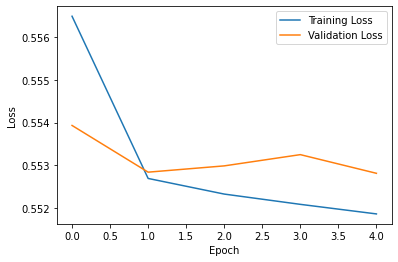

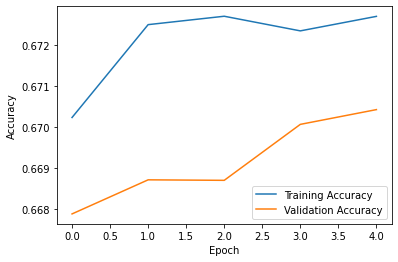

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()